# 基于超图神经网络选股论文复现

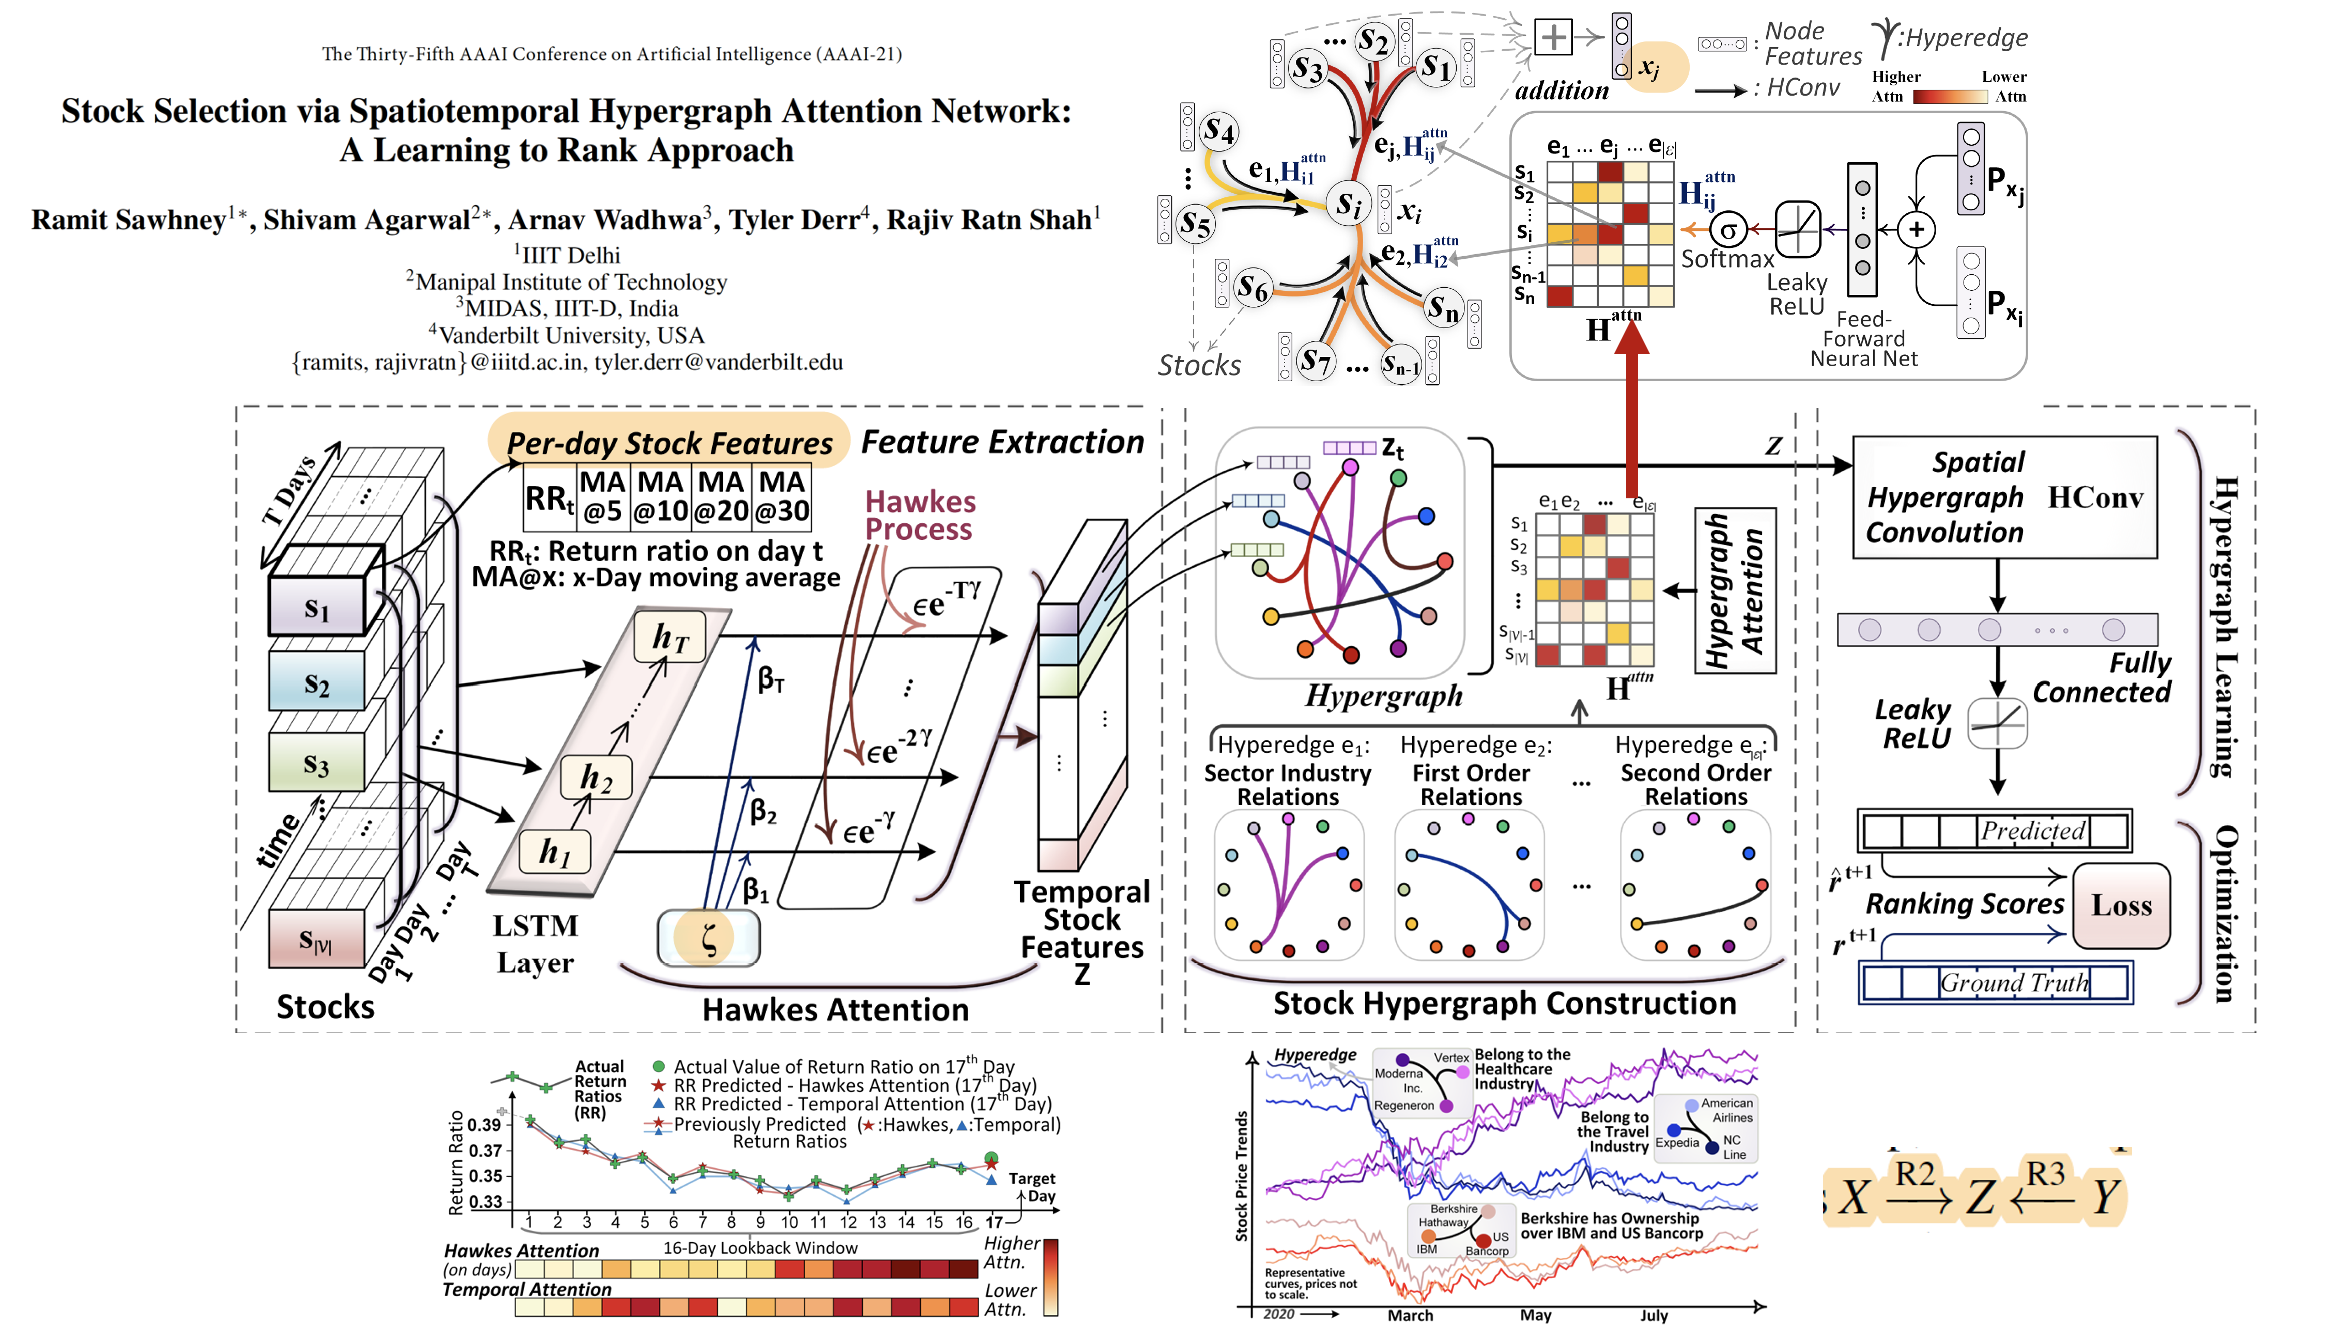

# 1 股票数据预处理（以NASDAQ为例）

## 1.1 数据准备

In [ ]:
import os
from datetime import datetime
import numpy as np
import pandas as pd

In [ ]:
import sys
sys.version

In [ ]:
data_path = '../STHAN_SR/data/google_finance'
data_market = 'NASDAQ'
date_format = '%Y-%m-%d %H:%M:%S'

In [ ]:
selected_tickers_fname = data_market + '_tickers_qualify_dr-0.98_min-5_smooth.csv'
begin_date = datetime.strptime('2012-11-19 00:00:00', date_format)
opath = os.path.join(data_path, '..', 'processed_data')
return_days=1
pad_begin=29 # offset for the first 30-days average

In [ ]:
# 交易日期获取
trading_dates = np.genfromtxt(os.path.join(data_path, '..', data_market + '_aver_line_dates.csv'),
                              dtype=str, delimiter=',', skip_header=False)
print('#trading dates:', len(trading_dates))

In [ ]:
print('#begin date:', begin_date)
# 将交易日映射为索引
index_tra_dates = {}
tra_dates_index = {}
for index, date in enumerate(trading_dates):
    tra_dates_index[date] = index
    index_tra_dates[index] = date

In [ ]:
# 股票索引
tickers = np.genfromtxt(os.path.join(data_path, '..', selected_tickers_fname),
                             dtype=str, delimiter='\t', skip_header=False)
print('#tickers selected:', len(tickers))

## 1.2 处理每日交易数据

### 1.2.1 全样本统一处理数据（原方法）

In [ ]:
data_EOD = []
for index, ticker in enumerate(tickers):
    single_EOD = np.genfromtxt(os.path.join(data_path, data_market + '_' + ticker +'_30Y.csv'),
                               dtype=str, delimiter=',',skip_header=True)
    data_EOD.append(single_EOD)

print('#stocks\' EOD data readin:', len(data_EOD))
assert len(tickers) == len(data_EOD), 'length of tickers and stocks not match'

In [ ]:
# 对每一个股票数据进行读取
for stock_index, single_EOD in enumerate(data_EOD):
    # 选取在指定交易日内的股票数据
    begin_date_row = -1
    for date_index, daily_EOD in enumerate(single_EOD):
        date_str = daily_EOD[0].replace('-05:00', '')
        date_str = date_str.replace('-04:00', '')
        cur_date = datetime.strptime(date_str, date_format)
        if cur_date > begin_date:
            begin_date_row = date_index
            break
    selected_EOD_str = single_EOD[begin_date_row:]
    
    # 将读取的文本str数据转换为numpy格式
    selected_EOD = np.zeros(selected_EOD_str.shape, dtype=float)
    for row, daily_EOD in enumerate(selected_EOD_str):
        date_str = daily_EOD[0].replace('-05:00', '')
        date_str = date_str.replace('-04:00', '')
        # 将交易日映射为索引
        selected_EOD[row][0] = tra_dates_index[date_str]
        # Open,High,Low,Close,Volume
        for col in range(1, selected_EOD_str.shape[1]):
            selected_EOD[row][col] = float(daily_EOD[col])

    # 计算移动平均特征
    begin_date_row = -1
    for row in range(selected_EOD.shape[0]):
        date_index = selected_EOD[row][0]
        if date_index >= pad_begin:
            begin_date_row = row
            break
    # 4 columns refers to 5-, 10-, 20-, 30-days average
    mov_aver_features = np.zeros([selected_EOD.shape[0], 4], dtype=float)
    for row in range(begin_date_row, selected_EOD.shape[0]):
        date_index = selected_EOD[row][0]
        aver_5 = 0.0
        aver_10 = 0.0
        aver_20 = 0.0
        aver_30 = 0.0
        count_5 = 0
        count_10 = 0
        count_20 = 0
        count_30 = 0
        # !!此处的平均特征计算有待商讨
        for offset in range(30):
            # 以统一的交易日区间计算gap
            date_gap = date_index - selected_EOD[row - offset][0]
            if date_gap < 5:
                count_5 += 1
                aver_5 += selected_EOD[row - offset][4]
            if date_gap < 10:
                count_10 += 1
                aver_10 += selected_EOD[row - offset][4]
            if date_gap < 20:
                count_20 += 1
                aver_20 += selected_EOD[row - offset][4]
            if date_gap < 30:
                count_30 += 1
                aver_30 += selected_EOD[row - offset][4]
        mov_aver_features[row][0] = aver_5 / count_5
        mov_aver_features[row][1] = aver_10 / count_10
        mov_aver_features[row][2] = aver_20 / count_20
        mov_aver_features[row][3] = aver_30 / count_30

    # !!以全区间最高收盘价标准化数据
    # 截止到此处 需要修改数据处理流程【时序交叉验证】
    pri_min = np.min(selected_EOD[begin_date_row:, 4])
    price_max = np.max(selected_EOD[begin_date_row:, 4])
    print(tickers[stock_index], 'minimum:', pri_min,
          'maximum:', price_max, 'ratio:', price_max / pri_min)
    if price_max / pri_min > 10:
        print('!!!!!!!!!')
    # open_high_low = (selected_EOD[:, 1:4] - price_min) / (price_max - price_min)
    mov_aver_features = mov_aver_features / price_max


    # 生成特征 [date_index, 5-day, 10-day, 20-day, 30-day, close price]
    # 用-1234填充没有交易的缺失值
    features = np.ones([len(trading_dates) - pad_begin, 6], dtype=float) * -1234
    
    for row in range(len(trading_dates) - pad_begin):
        features[row][0] = row
    for row in range(begin_date_row, selected_EOD.shape[0]):
        cur_index = int(selected_EOD[row][0])
        # 注意交易日索引
        features[cur_index - pad_begin][1:5] = mov_aver_features[row]
        # 这个return_days是干啥的？
        if cur_index - int(selected_EOD[row - return_days][0]) == return_days:
            # 若股票连续两条数据所在交易日不连续则改日收盘价记为-1234
            features[cur_index - pad_begin][-1] = selected_EOD[row][4] / price_max

    # write out
    np.savetxt(os.path.join(opath, data_market + '_' + tickers[stock_index] + '_' + str(return_days) + '.csv'),
               features, fmt='%.6f', delimiter=',')
    

### 1.2.2 时序交叉验证处理（改进方法）

In [ ]:
# 读取所有股票原始数据
data_EOD = []
for index, ticker in enumerate(tickers):
    single_EOD = np.genfromtxt(os.path.join(data_path, data_market + '_' + ticker +'_30Y.csv'),
                               dtype=str, delimiter=',',skip_header=True)
    data_EOD.append(single_EOD)

print('#stocks\' EOD data readin:', len(data_EOD))
assert len(tickers) == len(data_EOD), 'length of tickers and stocks not match'

In [ ]:
# 对每一个股票数据进行处理
# 定义几个特定时间
begin_date = datetime.strptime('2012-11-19 00:00:00', date_format)
date_2014 = datetime.strptime('2014-01-01 00:00:00', date_format)
date_2015 = datetime.strptime('2015-01-01 00:00:00', date_format)
date_2016 = datetime.strptime('2016-01-01 00:00:00', date_format)
date_2017 = datetime.strptime('2017-01-01 00:00:00', date_format)

for stock_index, single_EOD in enumerate(data_EOD):
    # 选取在指定交易日内的股票数据
    begin_date_row = -1
    analyse_date_row = [-1,-1,-1,-1]
    
    for date_index, daily_EOD in enumerate(single_EOD):
        date_str = daily_EOD[0].replace('-05:00', '')
        date_str = date_str.replace('-04:00', '')
        cur_date = datetime.strptime(date_str, date_format)
        # 2017年
        if analyse_date_row[3] == -1 and cur_date > date_2017:
            analyse_date_row[3] = date_index - begin_date_row
            break
        # 2016年
        if analyse_date_row[2] == -1 and cur_date > date_2016:
            analyse_date_row[2] = date_index - begin_date_row
        # 2015年
        if analyse_date_row[1] == -1 and cur_date > date_2015:
            analyse_date_row[1] = date_index - begin_date_row
        # 2014年
        if analyse_date_row[0] == -1 and cur_date > date_2014:
            analyse_date_row[0] = date_index - begin_date_row
        # 有效期内
        if begin_date_row == -1 and cur_date > begin_date:
            begin_date_row = date_index
    
    # 构造移动平均序列
    selected_EOD_str = single_EOD[begin_date_row:]
    # 将读取的文本str数据转换为numpy格式
    selected_EOD = np.zeros(selected_EOD_str.shape, dtype=float)
    for row, daily_EOD in enumerate(selected_EOD_str):
        date_str = daily_EOD[0].replace('-05:00', '')
        date_str = date_str.replace('-04:00', '')
        # 将交易日映射为索引
        selected_EOD[row][0] = tra_dates_index[date_str]
        # Open,High,Low,Close,Volume
        for col in range(1, selected_EOD_str.shape[1]):
            selected_EOD[row][col] = float(daily_EOD[col])
    analyse_date_row.append(selected_EOD.shape[0])

    # 计算移动平均特征
    begin_date_row = -1
    for row in range(selected_EOD.shape[0]):
        date_index = selected_EOD[row][0]
        if date_index >= pad_begin:
            begin_date_row = row
            break
    # 4 columns refers to 5-, 10-, 20-, 30-days average
    mov_aver_features = np.zeros([selected_EOD.shape[0], 4], dtype=float)
    for row in range(begin_date_row, selected_EOD.shape[0]):
        date_index = selected_EOD[row][0]
        aver_5 = 0.0
        aver_10 = 0.0
        aver_20 = 0.0
        aver_30 = 0.0
        count_5 = 0
        count_10 = 0
        count_20 = 0
        count_30 = 0
        for offset in range(30):
            # 以统一的交易日区间计算gap
            date_gap = date_index - selected_EOD[row - offset][0]
            if date_gap < 5:
                count_5 += 1
                aver_5 += selected_EOD[row - offset][4]
            if date_gap < 10:
                count_10 += 1
                aver_10 += selected_EOD[row - offset][4]
            if date_gap < 20:
                count_20 += 1
                aver_20 += selected_EOD[row - offset][4]
            if date_gap < 30:
                count_30 += 1
                aver_30 += selected_EOD[row - offset][4]
        mov_aver_features[row][0] = aver_5 / count_5
        mov_aver_features[row][1] = aver_10 / count_10
        mov_aver_features[row][2] = aver_20 / count_20
        mov_aver_features[row][3] = aver_30 / count_30
    
    # 构造时序交叉验证样本
    date_index = [281,533,785,1037,len(trading_dates)]
    for k in range(4):
        features_k = np.ones([date_index[k+1] - pad_begin, 6], dtype=float) * -1234
        for row in range(date_index[k+1] - pad_begin):
            features_k[row][0] = row

        # 训练集区间
        selected_EOD_k = selected_EOD[:analyse_date_row[k]] # 计算最大值的区间
        mov_aver_features_k = mov_aver_features[:analyse_date_row[k+1]]

        price_min = np.min(selected_EOD_k[:,4])
        price_max = np.max(selected_EOD_k[:,4])
        print(tickers[stock_index],' fold:',k+1, 'minimum:', price_min, 'maximum:', price_max, '1_ratio:', price_max / price_min)

        selected_EOD_k = selected_EOD[:analyse_date_row[k+1]] # 计算特征的区间
        mov_aver_features_k = mov_aver_features_k / price_max
        for row in range(begin_date_row, analyse_date_row[k+1]):
            cur_index = int(selected_EOD_k[row][0])
            # 注意交易日索引
            features_k[cur_index - pad_begin][1:5] = mov_aver_features_k[row]
            if cur_index - int(selected_EOD_k[row - return_days][0]) == return_days:
                # 若股票连续两条数据所在交易日不连续则记日收盘价记为-1234
                features_k[cur_index - pad_begin][-1] = selected_EOD_k[row][4] / price_max
        
        # write out
        np.savetxt(os.path.join(opath, data_market + '_' + tickers[stock_index] + '_' + str(k) + '.csv'),
               features_k, fmt='%.6f', delimiter=',')
    

### 1.2.3 股票数据可视化

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文(windows)
plt.rcParams['axes.unicode_minus'] = False   # 用来正常显示负号

In [ ]:
# 定义一个显示股价走势、波动率的函数
# title: 图片标题
# y_lable: 纵坐标含义
# stock_list: 需要可视化的股票列表（索引）
# visual_EOD: 股票数据 [股票数 * 交易日数 * 特征数]
# stock_trading_dates： 交易日期列表 [股票数 * 交易日数]
# unify_date: 是否使用统一交易日期列表 （展示原始股票走势图时，可能每只股票交易日数量不同）
def visual_stock_trend(title,y_lable,stock_list,visual_EOD,stock_trading_dates,unify_date):
    # 图片大小设置
    fig = plt.figure(figsize=(15,9), dpi=100)
    ax = fig.add_subplot(111)

    # X轴时间刻度格式 & 刻度显示
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    if(unify_date == True):
        print("#unify stock_trading_dates:shape",stock_trading_dates.shape)
        # 利用日期表中的数据制造日期间隔、并根据间隔将刻度（即索引）与文本（即日期）对齐
        xticks = list(range(0, len(stock_trading_dates), 20))
        xlabels = [str(stock_trading_dates[x]) for x in xticks]
    
    # 分别对每只股票可视化
    for i in range(len(stock_list)):
        stock_index = stock_list[i]
        visual_EOD_i = visual_EOD[i]
        stock_trading_dates_i = stock_trading_dates[i]
        print("#stock:{} visual_EOD shape:{}".format(stock_index,visual_EOD_i.shape))
        
        if(unify_date == False):
            print("#stock:{} stock_trading_dates shape:{}".format(stock_index,stock_trading_dates.shape))
            # 利用日期表中的数据制造日期间隔、并根据间隔将刻度（即索引）与文本（即日期）对齐
            xticks = list(range(0, len(stock_trading_dates_i), 20))
            xlabels = [str(stock_trading_dates_i[x]) for x in xticks]

            # 绘图
            ax.plot(stock_trading_dates_i,list(map(float, visual_EOD_i)), label=tickers[stock_index])
        else:
            print("#stock:{} stock_trading_dates shape:{}".format(stock_index,stock_trading_dates.shape))
            # 绘图
            ax.plot(stock_trading_dates,list(map(float, visual_EOD_i)), label=tickers[stock_index])

    plt.xlabel('交易日期', fontsize=14)    # X轴标签
    plt.ylabel(ylable, fontsize=16)         # Y轴标签
    ax.legend()                              # 图例
    plt.title(title, fontsize=20, color='black', pad=20)

    # 作图完成后，配置对x轴的设置
    plt.xticks(rotation=30)
    plt.xticks(ticks=xticks, labels=xlabels)

    plt.show()

In [ ]:
# 单只股票走势图（标准化之前）
# 选取股票列表
stock_list = [1,5,7]
# 准备可视化数据
visual_EOD_ = []
stock_trading_dates_ = []
for stock_index in stock_list:
    visual_EOD = np.genfromtxt(os.path.join(data_path, data_market + '_' + tickers[stock_index] +'_30Y.csv'),
                               dtype=str, delimiter=',',skip_header=True)
    # 选取在指定交易日内的股票数据
    begin_date_visual = datetime.strptime('2013-01-01 00:00:00', date_format)
    begin_date_row = -1
    for date_index, daily_EOD in enumerate(visual_EOD):
        date_str = daily_EOD[0].replace('-05:00', '')
        date_str = date_str.replace('-04:00', '')
        cur_date = datetime.strptime(date_str, date_format)
        if cur_date > begin_date_visual:
            begin_date_row = date_index
            break
    visual_EOD = visual_EOD[begin_date_row:]
    visual_EOD_.append(visual_EOD[:,4])
    
    # 提取日期
    stock_trading_dates = visual_EOD[:,0]
    for i in range(len(stock_trading_dates)):
        date = stock_trading_dates[i].split(' ')
        stock_trading_dates[i] = str(date[0])
    stock_trading_dates_.append(stock_trading_dates)

visual_EOD_ = np.array(visual_EOD_)
stock_trading_dates_ = np.array(stock_trading_dates_)
title = '单只股票走势图（标准化之前）'
ylable = '收盘价'
visual_stock_trend(title,ylable,stock_list,visual_EOD_,stock_trading_dates_,unify_date=False)
    

In [ ]:
# 处理后的结果可视化
date_index = [282,534,786,1038,len(trading_dates)]
# 选择某只股票
for k in range(4):
    # 准备可视化数据
    visual_EOD_ = []
    # 提取日期
    stock_trading_dates_ = trading_dates[pad_begin:date_index[k+1]-1]
    for i in range(len(stock_trading_dates_)):
        date = stock_trading_dates_[i].split(' ')
        stock_trading_dates_[i] = str(date[0])
    for stock_index in stock_list:
        visual_EOD = np.genfromtxt(os.path.join(data_path,'..','processed_data', data_market + '_' + tickers[stock_index] +'_'+str(k)+'.csv'),
                                   dtype=str, delimiter=',',skip_header=False)
        if k == 3:
            visual_EOD = visual_EOD[:-1]
        visual_EOD_.append(visual_EOD[:,-1]) #取收盘价一列

    visual_EOD_ = np.array(visual_EOD_)
    stock_trading_dates_ = np.array(stock_trading_dates_)
    title = '单只股票走势图（标准化之后）'
    ylable = '收盘价'
    visual_stock_trend(title,ylable,stock_list,visual_EOD_,stock_trading_dates_,unify_date=True)


## 1.3 处理股票关系数据

### 1.3.1 处理行业关联关系

In [ ]:
import json

In [ ]:
industry_ticker_file = os.path.join(data_path, '..', 'relation/sector_industry/NASDAQ_industry_ticker.json')

selected_tickers = np.genfromtxt(
    os.path.join(data_path, '..', selected_tickers_fname),
    dtype=str, delimiter='\t', skip_header=False
)
print('#tickers selected:', len(selected_tickers))
# 建立股票索引
ticker_index = {}
for index, ticker in enumerate(selected_tickers):
    ticker_index[ticker] = index

# 提取行业数据
with open(industry_ticker_file, 'r') as fin:
    industry_tickers = json.load(fin)
print('#industries: ', len(industry_tickers))
# 建立行业索引
industry_index = {}
for index, industry in enumerate(industry_tickers.keys()):
    industry_index[industry] = index

In [ ]:
# 建立邻接矩阵[len(selected_tickers), len(industry_tickers)]
# 列代表超边
ticker_relation_embedding = np.zeros([len(selected_tickers), len(industry_tickers)], dtype=int)
print(ticker_relation_embedding.shape)


In [ ]:
# 读取每个行业的股票
for industry in industry_tickers.keys():
    if len(industry_tickers[industry]) > 0:
        cur_ind_tickers = industry_tickers[industry]
        # 提取行业编号
        ind_ind = industry_index[industry]
        
        for i in range(len(cur_ind_tickers)):
            # 提取出股票编号
            tic_ind = ticker_index[cur_ind_tickers[i]]
            ticker_relation_embedding[tic_ind][ind_ind] = 1

In [ ]:
ticker_relation_embedding[:10,:20]

### 1.3.2 处理wikidata关系

In [ ]:
connection_file = os.path.join(data_path , '..', 'relation/wikidata/NASDAQ_connections.json')
tic_wiki_file = os.path.join(data_path , '..', 'NASDAQ_wiki.csv')
sel_path_file = os.path.join(data_path , '..', 'relation/wikidata/selected_wiki_connections.csv')

In [ ]:
# 读取股票数据
tickers = np.genfromtxt(tic_wiki_file, dtype=str, delimiter=',', skip_header=False)
print('#tickers selected:', tickers.shape[0])

# 在wikidata中有关联关系的股票
wikiid_ticind_dic = {}
for ind, tw in enumerate(tickers):
    if not tw[-1] == 'unknown':
        wikiid_ticind_dic[tw[-1]] = ind
print('#tickers aligned:', len(wikiid_ticind_dic))

In [ ]:
# readin selected paths/connections
sel_paths = np.genfromtxt(sel_path_file, dtype=str, delimiter=' ', skip_header=False)
print('#paths selected:', len(sel_paths))
sel_paths = set(sel_paths[:, 0])

In [ ]:
# readin connections
with open(connection_file, 'r') as fin:
    connections = json.load(fin)
print('#connection items:', len(connections))

In [ ]:
# get occured paths
occur_paths = set()
# 关系类型 sou_item -path_key(r)- tar_item
for sou_item, conns in connections.items():
    for tar_item, paths in conns.items():
        for p in paths:
            path_key = '_'.join(p)
            if path_key in sel_paths:
                occur_paths.add(path_key)
print('#NASDAQ relation type:',len(occur_paths))

In [ ]:
# 建立关系索引
valid_path_index = {}
for ind, path in enumerate(occur_paths):
    valid_path_index[path] = ind
print('#valid paths:', len(valid_path_index))

for path, ind in valid_path_index.items():
    print(path, ind)
print('\n')
# 建立邻接矩阵[len(tickers), len(valid_path_index)]
# 列代表超边
wiki_relation_embedding = np.zeros([tickers.shape[0], len(valid_path_index)], dtype=int)
print(wiki_relation_embedding.shape)

In [ ]:
# 读取股票之间的关系
conn_count = 0
for sou_item, conns in connections.items():
    for tar_item, paths in conns.items():
        for p in paths:
            path_key = '_'.join(p)
            if path_key in valid_path_index.keys():
                sou_item_index = wikiid_ticind_dic[sou_item]
                tar_item_index = wikiid_ticind_dic[tar_item]
                path_index = valid_path_index[path_key]
                
                # 第一类关系超边：source - [targets]
                # 第二类关系超边：一对一
                wiki_relation_embedding[sou_item_index][path_index] = 1
                wiki_relation_embedding[tar_item_index][path_index] = 1
                
                conn_count += 1
print('#connections count:', conn_count, 'ratio:', conn_count / float(tickers.shape[0] * tickers.shape[0]))


In [ ]:
wiki_relation_embedding[:10,:20]

### 1.3.3 将两类关系合并

In [ ]:
relation_embedding = np.concatenate((ticker_relation_embedding,wiki_relation_embedding),axis=1)

In [ ]:
relation_embedding.shape

In [ ]:
# 保存数据
np.save(os.path.join(data_path,'..','relation', data_market + '_relation'), relation_embedding)

# 2 数据加载

## 2.1 加载股票数据（样本统一处理）

In [ ]:
data_path = '../STHAN_SR/data/2013-01-01/'
market_name = 'NASDAQ'
tickers_fname = market_name + '_tickers_qualify_dr-0.98_min-5_smooth.csv'
relation_name = 'sector_industry' # sector_industry or wikidata

steps = 1 #单步预测

In [ ]:
# load data
tickers = np.genfromtxt(os.path.join(data_path, '..', tickers_fname),
                        dtype=str, delimiter='\t', skip_header=False)
print('#tickers selected:', len(tickers))

In [ ]:
# 读取eod数据函数
def load_EOD_data(data_path, market_name, tickers, steps=1):
    eod_data = []
    masks = []
    ground_truth = []
    base_price = []
    for index, ticker in enumerate(tickers):
        single_EOD = np.genfromtxt(
            os.path.join(data_path, market_name + '_' + ticker + '_1.csv'),
            dtype=np.float32, delimiter=',', skip_header=False
        )
        if market_name == 'NASDAQ':
            # remove the last day since lots of missing data
            single_EOD = single_EOD[:-1, :]
        if index == 0:
            print('#single EOD data shape:', single_EOD.shape)  #days*6
            eod_data = np.zeros([len(tickers), single_EOD.shape[0], single_EOD.shape[1] - 1], dtype=np.float32)
            masks = np.ones([len(tickers), single_EOD.shape[0]], dtype=np.float32)  #tickers*days
            ground_truth = np.zeros([len(tickers), single_EOD.shape[0]], dtype=np.float32)
            base_price = np.zeros([len(tickers), single_EOD.shape[0]], dtype=np.float32)
        for row in range(single_EOD.shape[0]):
            # ！！当日收盘价一栏（return_day）为-1234 mask设置为0
            if abs(single_EOD[row][-1] + 1234) < 1e-8:
                masks[index][row] = 0.0                         
            elif row > steps - 1 and abs(single_EOD[row - steps][-1] + 1234) > 1e-8:
                # 收益率
                ground_truth[index][row] = \
                    (single_EOD[row][-1] - single_EOD[row - steps][-1]) / single_EOD[row - steps][-1]
            for col in range(single_EOD.shape[1]):
                if abs(single_EOD[row][col] + 1234) < 1e-8:
                    # !!为何设置为1.1
                    single_EOD[row][col] = 1.1
        eod_data[index, :, :] = single_EOD[:, 1:]
        base_price[index, :] = single_EOD[:, -1]
    return eod_data, masks, ground_truth, base_price

In [ ]:
eod_data, mask_data, gt_data, price_data = load_EOD_data(data_path, market_name, tickers, steps)

In [ ]:
print("#eod_data.shape:",eod_data.shape) # [股票数, 交易日数, 五维特征(5-day, 10-day, 20-day, 30-day, close price)]
print("#mask_data.shape:",mask_data.shape) # [股票数, 交易日数]
print("#gt_data.shape:",gt_data.shape) #  [股票数, 交易日数]
print("#price_data.shape:",price_data.shape) # [股票数, 交易日数]

## 2.1 加载股票数据（时序交叉）

In [ ]:
data_path = '../STHAN_SR/data/processed_data/'
market_name = 'NASDAQ'
tickers_fname = market_name + '_tickers_qualify_dr-0.98_min-5_smooth.csv'
steps = 1 #单步预测

tickers = np.genfromtxt(os.path.join(data_path, '..', tickers_fname),
                        dtype=str, delimiter='\t', skip_header=False)
print('#tickers selected:', len(tickers))

In [ ]:
# 读取时序交叉eod数据函数
def load_EOD_data(data_path, market_name, tickers, steps=1):
    eod_data = []
    masks = []
    ground_truth = []
    base_price = []
    
    for k in range(4):
        eod_data_k = []
        masks_k = []
        ground_truth_k = []
        base_price_k = []
        for index, ticker in enumerate(tickers): 
            single_EOD = np.genfromtxt(
                os.path.join(data_path, market_name + '_' + ticker + '_'+str(k)+'.csv'),
                dtype=np.float32, delimiter=',', skip_header=False
            )
            if market_name == 'NASDAQ' and k == 3:
                # remove the last day since lots of missing data
                single_EOD = single_EOD[:-1, :]
            if index == 0:
                print('#fold:'+str(k)+' single EOD data shape:', single_EOD.shape)  #days*6
                eod_data_k = np.zeros([len(tickers), single_EOD.shape[0], single_EOD.shape[1] - 1], dtype=np.float32)
                masks_k = np.ones([len(tickers), single_EOD.shape[0]], dtype=np.float32)  #tickers*days
                ground_truth_k = np.zeros([len(tickers), single_EOD.shape[0]], dtype=np.float32)
                base_price_k = np.zeros([len(tickers), single_EOD.shape[0]], dtype=np.float32)
            for row in range(single_EOD.shape[0]):
                # ！！当日收盘价一栏（return_day）为-1234 mask设置为0
                if abs(single_EOD[row][-1] + 1234) < 1e-8:
                    masks_k[index][row] = 0.0                         
                elif row > steps - 1 and abs(single_EOD[row - steps][-1] + 1234) > 1e-8:
                    # 收益率
                    ground_truth_k[index][row] = (single_EOD[row][-1] - single_EOD[row - steps][-1]) / single_EOD[row - steps][-1]
                for col in range(single_EOD.shape[1]):
                    if abs(single_EOD[row][col] + 1234) < 1e-8:
                        single_EOD[row][col] = 2.0
            eod_data_k[index, :, :] = single_EOD[:, 1:]
            base_price_k[index, :] = single_EOD[:, -1]
            
        eod_data.append(eod_data_k.tolist())
        masks.append(masks_k.tolist())
        ground_truth.append(ground_truth_k.tolist())
        base_price.append(base_price_k.tolist())
    return eod_data, masks, ground_truth, base_price

In [ ]:
# eod_data[k折 * 股票数 * 每折天数 * 特征数]
# [504,756,1008,1245]
# mask_data[k折 * 股票数 * 每折天数]
# gt_data[k折 * 股票数 * 每折天数]
# price_data[k折 * 股票数 * 每折天数]
eod_data, mask_data, gt_data, price_data = load_EOD_data(data_path, market_name, tickers, steps)

### 2.1.1 特征数据统计分析

In [ ]:
# # 特征数据统计分析(样本统一分析)
# stock_index = 1

# print("# stock:{} before {}:".format(tickers[stock_index],trading_dates[756+pad_begin]))
# eod_data_df = pd.DataFrame(eod_data[stock_index][:756])
# print(eod_data_df.describe())

# print("# stock:{} between {} and {}:".format(tickers[stock_index],trading_dates[756+pad_begin],trading_dates[1008+pad_begin]))
# eod_data_df = pd.DataFrame(eod_data[stock_index][756:1008])
# print(eod_data_df.describe())

# print("# stock:{} after {}:".format(tickers[stock_index],trading_dates[1008+pad_begin]))
# eod_data_df = pd.DataFrame(eod_data[stock_index][1008:])
# print(eod_data_df.describe())

# 特征数据统计分析（时序交叉）
stock_index = 1

for k in range(4):
    print("# fold:{} stock:{}".format(k,tickers[stock_index]))
    eod_data_df = pd.DataFrame(eod_data[k][stock_index])
    print(eod_data_df.describe())


In [ ]:
# 特征可视化
date_index = [282,534,786,1038,len(trading_dates)]
stock_list = [1,5,7]

for k in range(4):
    # 提取日期
    stock_trading_dates = trading_dates[pad_begin:date_index[k+1]-1]
    for i in range(len(stock_trading_dates)):
        date = stock_trading_dates[i].split(' ')
        stock_trading_dates[i] = str(date[0])
    # 利用日期表中的数据制造日期间隔、并根据间隔将刻度（即索引）与文本（即日期）对齐
    xticks = list(range(0, len(stock_trading_dates), 20))
    xlabels = [str(stock_trading_dates[x]) for x in xticks]

    # 选择某只股票
    for stock_index in stock_list:
        # 图片大小设置
        fig = plt.figure(figsize=(15,9), dpi=100)
        ax = fig.add_subplot(111)

        # X轴时间刻度格式 & 刻度显示
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

        # 提取特征数据
        visual_EOD = eod_data[k][stock_index]
        visual_EOD = visual_EOD[:date_index[k+1]-pad_begin]
        visual_EOD = np.array(visual_EOD)
        print("#visual_EOD shape:",visual_EOD.shape)

        # 绘图
        ax.plot(stock_trading_dates,visual_EOD[:,0],color='y', label=tickers[stock_index]+'_5mean'+'_fold'+str(k))
        ax.plot(stock_trading_dates,visual_EOD[:,1],color='g', label=tickers[stock_index]+'_10mean'+'_fold'+str(k))
        ax.plot(stock_trading_dates,visual_EOD[:,2],color='b', label=tickers[stock_index]+'_20mean'+'_fold'+str(k))
        ax.plot(stock_trading_dates,visual_EOD[:,3],color='m', label=tickers[stock_index]+'_30mean'+'_fold'+str(k))
        ax.plot(stock_trading_dates,visual_EOD[:,4],color='r', label=tickers[stock_index]+'_close'+'_fold'+str(k))

        plt.xlabel('交易日期', fontsize=14)    # X轴标签
        plt.ylabel("特征", fontsize=16)         # Y轴标签
        ax.legend()                              # 图例
        plt.title("股票特征", fontsize=20, color='black', pad=20)

        # 作图完成后，配置对x轴的设置
        plt.xticks(rotation=30)
        plt.xticks(ticks=xticks, labels=xlabels)

        plt.show()
    

In [ ]:
# 特征可视化
for k in range(4):
    # 提取日期
    stock_trading_dates = trading_dates[pad_begin:date_index[k+1]-1]
    for i in range(len(stock_trading_dates)):
        date = stock_trading_dates[i].split(' ')
        stock_trading_dates[i] = str(date[0])

    # 利用日期表中的数据制造日期间隔、并根据间隔将刻度（即索引）与文本（即日期）对齐
    xticks = list(range(0, len(stock_trading_dates), 20))
    xlabels = [str(stock_trading_dates[x]) for x in xticks]
    
    # 选择某只股票
    for stock_index in stock_list:
        # 图片大小设置
        fig = plt.figure(figsize=(15,9), dpi=100)
        ax = fig.add_subplot(111)

        # X轴时间刻度格式 & 刻度显示
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

        # 提取特征数据
        visual_EOD = gt_data[k][stock_index]
        visual_EOD = np.array(visual_EOD)
        print('# visual_EOD shape:',visual_EOD.shape)

        # 绘图
        ax.plot(stock_trading_dates,visual_EOD,color='r', label=tickers[stock_index]+'_fold'+str(k))

        plt.xlabel('交易日期', fontsize=14)    # X轴标签
        plt.ylabel("波动率", fontsize=16)         # Y轴标签
        ax.legend()                              # 图例
        plt.title("单只股票波动率", fontsize=20, color='black', pad=20)

        # 作图完成后，配置对x轴的设置
        plt.xticks(rotation=30)
        plt.xticks(ticks=xticks, labels=xlabels)

        plt.show()

### 2.2 加载股票关系数据

In [ ]:
from scipy import sparse
from torch_geometric import utils

rel_data_path = '../STHAN_SR/data/relation/NASDAQ_relation.npy'
inci_mat = np.load(rel_data_path)
print("#inci_mat:",inci_mat.shape)
inci_sparse = sparse.coo_matrix(inci_mat)
print("#inci_sparse:",inci_sparse.shape)
# 每条边的权重都为1
# 2*edge_num
incidence_edge = utils.from_scipy_sparse_matrix(inci_sparse)
print("#incidence_edge:",incidence_edge[0].shape)

# 3 网络架构

In [ ]:
from torch_geometric import nn
import torch
import torch.nn.functional as F
import torch.nn
import torch.optim as optim

In [ ]:

class Attention(torch.nn.Module):

    def __init__(self, dimensions, attention_type='general'):
        super(Attention, self).__init__()

        if attention_type not in ['dot', 'general']:
            raise ValueError('Invalid attention type selected.')

        self.attention_type = attention_type
        if self.attention_type == 'general':
            self.linear_in = torch.nn.Linear(dimensions, dimensions, bias=False)

        self.linear_out = torch.nn.Linear(dimensions * 2, dimensions, bias=False)
        self.softmax = torch.nn.Softmax(dim=-1)
        self.tanh = torch.nn.Tanh()
        self.ae = torch.nn.Parameter(torch.FloatTensor(1026,1,1))
        self.ab = torch.nn.Parameter(torch.FloatTensor(1026,1,1))

    def forward(self, query, context):
        batch_size, output_len, dimensions = query.size()
        query_len = context.size(1)

        if self.attention_type == "general":
            query = query.reshape(batch_size * output_len, dimensions)
            query = self.linear_in(query)
            query = query.reshape(batch_size, output_len, dimensions)

        attention_scores = torch.bmm(query, context.transpose(1, 2).contiguous())

        # Compute weights across every context sequence
        attention_scores = attention_scores.view(batch_size * output_len, query_len)
        attention_weights = self.softmax(attention_scores)
        attention_weights = attention_weights.view(batch_size, output_len, query_len)


        mix = attention_weights*(context.permute(0,2,1))

        # ！！Hawkes Attention
        delta_t = torch.flip(torch.arange(0, query_len), [0]).type(torch.float32).to('cuda')
        delta_t = delta_t.repeat(1026,1).reshape(1026,1,query_len)
        bt = torch.exp(-1*self.ab * delta_t)
        term_2 = F.relu(self.ae * mix * bt)
        mix = torch.sum(term_2+mix, -1).unsqueeze(1)
        combined = torch.cat((mix, query), dim=2)
        combined = combined.view(batch_size * output_len, 2 * dimensions)

        output = self.linear_out(combined).view(batch_size, output_len, dimensions)
        output = self.tanh(output)

        return output, attention_weights

class gru(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(gru, self).__init__()
        self.gru1 = torch.nn.GRU(input_size = input_size, hidden_size=hidden_size, batch_first=True)
    def forward(self, inputs):
        full, last  = self.gru1(inputs)
        return full,last
    
class HGAT(torch.nn.Module):
    def __init__(self, tickers):
        super(HGAT, self).__init__()
        self.tickers = tickers
        self.grup = gru(5,32)  #or lstm
        self.attention = Attention(32)
        self.hatt1 = nn.HypergraphConv(32, 32, use_attention=True, heads=4, concat=False, negative_slope=0.2, dropout=0.5, bias=True)
        self.hatt2 = nn.HypergraphConv(32, 32, use_attention=True, heads=1, concat=False, negative_slope=0.2, dropout=0.5, bias=True)
        self.liear = torch.nn.Linear(32,1)
    def forward(self,price_input,e,num_edges,device):
        context,query  = self.grup(price_input)
        query = query.reshape(1026,1,32)
        output, weights = self.attention(query, context)
        output = output.reshape((1026,32))
        hyperedge_attr = torch.randn((num_edges, 32)).to(device)

        x = F.leaky_relu(self.hatt1(output,e,hyperedge_attr = hyperedge_attr), 0.2)
        x = F.leaky_relu(self.hatt2(x,e,hyperedge_attr = hyperedge_attr), 0.2)
        return F.leaky_relu(self.liear(x))
    

# 4 模型训练

## 4.1 模型超参数设定

In [ ]:
# self.parameters = copy.copy(parameters)
parameters = {'seq': 16, # length of historical sequence for feature
              'unit': 64, # number of hidden units in lstm
              'lr': 0.001, # learning rate
              'alpha': 1 # the weight of ranking loss
             }
epochs = 5
batch_size = len(tickers) 

# 数据集划分
trade_dates = 1245
train_index = [0,252,504,756,1008]
valid_index = [252,504,756,1008,1245]
test_index = 1008

fea_dim = 5
num_edges = inci_mat.shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #单卡gpu
gpu = True

## 4.2 设备、模型、优化器定义

In [ ]:
# 定义设备
if gpu == True:
    device_name = torch.cuda.get_device_name()
else:
    device_name = '/cpu:0'
print('device name:', device_name)

## 4.3 批量读取数据

In [ ]:
def get_batch(eod_data, mask_data, gt_data, price_data,seq_len,offset):
    mask_batch = mask_data[:, offset: offset + seq_len + steps]
    mask_batch = np.min(mask_batch, axis=1)
    return eod_data[:, offset:offset + seq_len, :],\
            np.expand_dims(mask_batch, axis=1),\
            np.expand_dims(price_data[:, offset + seq_len - 1], axis=1),\
            np.expand_dims(gt_data[:, offset + seq_len + steps - 1], axis=1)

In [ ]:
# 2*edge_num
hyp_input = incidence_edge[0].to(device)

## 4.4 定义损失函数

In [ ]:
# 损失函数
def weighted_mse_loss(input, target, weight):
    return torch.mean(weight * (input - target) ** 2)

def trr_loss_mse_rank(pred, base_price, ground_truth, mask, alpha, no_stocks):
    return_ratio = torch.div((pred- base_price), base_price)
    reg_loss = weighted_mse_loss(return_ratio, ground_truth, mask)
    all_ones = torch.ones(no_stocks,1).to(device)
    pre_pw_dif =  (torch.matmul(return_ratio, torch.transpose(all_ones, 0, 1)) 
                    - torch.matmul(all_ones, torch.transpose(return_ratio, 0, 1)))
    gt_pw_dif = (
            torch.matmul(all_ones, torch.transpose(ground_truth,0,1)) -
            torch.matmul(ground_truth, torch.transpose(all_ones, 0,1))
        )

    mask_pw = torch.matmul(mask, torch.transpose(mask, 0,1))
    rank_loss = torch.mean(
            F.relu(
                ((pre_pw_dif*gt_pw_dif)*mask_pw)))
    loss = reg_loss + alpha*rank_loss
    del mask_pw, gt_pw_dif, pre_pw_dif, all_ones
    return loss, reg_loss, rank_loss, return_ratio

## 4.5 模型指标计算及选股回测

In [ ]:
import math
import scipy.stats as sps
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import ndcg_score
from empyrical.stats import max_drawdown, downside_risk, calmar_ratio

def evaluate(prediction, ground_truth, mask, report=False):
    assert ground_truth.shape == prediction.shape, 'shape mis-match'
    # print('gt_rt',np.max(ground_truth))
    performance = {}
    performance['mse'] = np.linalg.norm((prediction - ground_truth) * mask)**2 / np.sum(mask)
    
    bt_long5 = 1.0
    bt_long5_gt = 1.0
    ndcg_score_top5 = 0.0
    sharpe_li5 = []
    irr = []
    selected_stock5 = []

    for i in range(prediction.shape[1]):
        # 返回索引
        rank_gt = np.argsort(ground_truth[:, i])
        # 真实前5名排序
        gt_top5 = set()
        for j in range(1, prediction.shape[0] + 1):
            cur_rank = rank_gt[-1 * j]
            if mask[cur_rank][i] < 0.5:
                continue
            if len(gt_top5) < 5:
                gt_top5.add(cur_rank)

        # 预测前5名排序
        rank_pre = np.argsort(prediction[:, i])
        pre_top5 = set()
        for j in range(1, prediction.shape[0] + 1):
            cur_rank = rank_pre[-1 * j]
            if mask[cur_rank][i] < 0.5:
                continue
            if len(pre_top5) < 5:
                pre_top5.add(cur_rank)
        # 保存选股
        selected_stock5.append(pre_top5)

        ndcg_score_top5 += ndcg_score(np.array(list(gt_top5)).reshape(1,-1), np.array(list(pre_top5)).reshape(1,-1))

        # back testing on top 5
        real_ret_rat_top5 = 0
        for pre in pre_top5:
            real_ret_rat_top5 += ground_truth[pre][i]
        real_ret_rat_top5 /= 5
        # 累计收益率计算公式
        bt_long5 *= (1+real_ret_rat_top5)
        sharpe_li5.append(real_ret_rat_top5)
        irr.append(bt_long5)

    performance['btl5'] = bt_long5 - 1
    performance['ndcg_score_top5'] = ndcg_score_top5/prediction.shape[1]
    sharpe_li5 = np.array(sharpe_li5)
    performance['sharpe5'] = (np.mean(sharpe_li5)/np.std(sharpe_li5))*15.87 #To annualize

    # 返回技术指标[mse,ndcg_score_top5,btl5(累计收益率),sharpe5(夏普比率)]
    # irr: 收益率序列
    # selected_stock5: 选股序列
    return performance,irr,selected_stock5


## 4.6 模型训练

In [ ]:
from time import time
from tqdm import tqdm
import copy

### 4.6.1 在训练集上训练 验证集上验证效果

In [ ]:
# 准备训练集下标集合
batch_offsets = []
for k in range(4):
    batch_offsets_k = np.arange(start=0, stop=train_index[k+1] - parameters['seq'] - steps +1, dtype=int)
    batch_offsets.append(batch_offsets_k)

####################--grid数据记录--###############################
tra_loss_grid = [] # 记录每个grid每折的训练损失
val_loss_grid = [] # 记录每个grid每折的验证损失

val_pred_grid = [] # 记录每个grid每折的最后一个epoch验证预测收益率序列
val_output_grid = [] # 记录每个grid每折的最后一个epoch验证预测收盘价序列

val_ndcg_score_top5_grid = [] #记录每个grid每折的验证ndcg5
val_irr_grid = [] # 记录每个grid每折的验证收益率序列
val_btl5_grid = [] # 记录每个grid每折的验证集累计收益率
val_sharpe5_grid = [] # 记录每个grid每折的验证集夏普比率
# 网格搜索超参数
# for lr in [0.0001,0.0005,0.0007,0.0009,0.001,0.003,0.005]:
#     for alpha in [1,2,3,4,5,6,7,8,9,10]:
for lr in [0.005]:
    for alpha in [3]:
        parameters['lr'] = lr
        parameters['alpha'] = alpha
        
        # 定义模型
        model = HGAT(batch_size).to(device)
        # 初始化参数，设置优化器
        for p in model.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)
            else:
                torch.nn.init.uniform_(p)
        optimizer_hgat = optim.Adam(model.parameters(), lr=parameters['lr'], weight_decay=5e-4)
        
        # 每一个epoch训练
        ####################--epoch数据记录--###############################
        # 模型选择指标
        tra_loss_epoch = [] # 记录第k折每个epoch的训练损失
        val_loss_epoch = [] # 记录第k折每个epoch验证损失

        # 模型效果指标
        val_pred_epoch = [] # 记录每折的最后一个epoch验证预测收益率序列
        val_output_epoch = [] # 记录每折的最后一个epoch验证预测收盘价序列

        val_ndcg_score_top5_epoch = [] #记录每个训练epoch的验证ndcg5
        val_irr_epoch = [] # 记录每个epoch的验证收益率序列
        val_btl5_epoch = [] # 记录每个训练epoch的验证集累计收益率
        val_sharpe5_epoch = [] # 记录每个epoch的验证集夏普比率
        
        for i in range(epochs):
            ####################--k折数据记录--###############################
            # 模型选择指标
            tra_loss_k = [] # 记录每折的训练损失
            val_loss_k = [] # 记录每折的验证损失

            # 模型效果指标
            val_pred_k = [] # 记录每折的最后一个epoch验证预测收益率序列
            val_output_k = [] # 记录每折的最后一个epoch验证预测收盘价序列

            val_ndcg_score_top5_k = [] #记录每折的验证ndcg5
            val_irr_k = [] # 记录每折的验证收益率序列
            val_btl5_k = [] # 记录每折的验证集累计收益率
            val_sharpe5_k = [] # 记录每折的验证集夏普比率
            
            # 每一折训练
            for k in range(4):
                print('#lr={},alpha={},epoch={},fold={}'.format(lr,alpha,i,k))
                # 准备第k折的数据
                eod_data_k = np.array(eod_data[k])
                mask_data_k = np.array(mask_data[k])
                gt_data_k = np.array(gt_data[k])
                price_data_k = np.array(price_data[k])
                # 索引下标
                batch_offsets_k = np.array(batch_offsets[k])
                np.random.shuffle(batch_offsets_k)
                    
                tra_loss = 0.0
                tra_reg_loss = 0.0
                tra_rank_loss = 0.0
                model.train() 
                for j in tqdm(range(train_index[k+1] - parameters['seq'] - steps +1)):
                    
                    # 获取一个批次的数据
                    emb_batch, mask_batch, price_batch, gt_batch = \
                        get_batch(eod_data_k, mask_data_k, gt_data_k, price_data_k,parameters['seq'],batch_offsets_k[j])

                    optimizer_hgat.zero_grad()
                    output = model(torch.FloatTensor(emb_batch).to(device), hyp_input, num_edges, device)
                    cur_loss, cur_reg_loss, cur_rank_loss, curr_rr_train = trr_loss_mse_rank(output.reshape((1026,1)), torch.FloatTensor(price_batch).to(device), 
                                                                                            torch.FloatTensor(gt_batch).to(device), 
                                                                                            torch.FloatTensor(mask_batch).to(device), 
                                                                                            parameters['alpha'], batch_size)
                    tra_loss += cur_loss.item()
                    tra_reg_loss += cur_reg_loss.item()
                    tra_rank_loss += cur_rank_loss.item()
                    cur_loss.backward()
                    optimizer_hgat.step()
                
                tra_loss = tra_loss / (train_index[k+1] - parameters['seq'] - steps + 1)
                tra_reg_loss = tra_reg_loss / (train_index[k+1] - parameters['seq'] - steps + 1)
                tra_rank_loss = tra_rank_loss / (train_index[k+1] - parameters['seq'] - steps + 1)
                print('Train Loss:',tra_loss,tra_reg_loss,tra_rank_loss)
                # 记录
                tra_loss_k.append(tra_loss)

                with torch.no_grad():
                    # test on validation set
                    valid_index_begin = valid_index[k] - parameters['seq']
                    valid_index_end = valid_index[k+1] - parameters['seq']
                    cur_valid_out = np.zeros([len(tickers), valid_index_end - valid_index_begin],dtype=float)
                    cur_valid_pred = np.zeros([len(tickers), valid_index_end - valid_index_begin],dtype=float)
                    cur_valid_gt = np.zeros([len(tickers), valid_index_end - valid_index_begin],dtype=float)
                    cur_valid_mask = np.zeros([len(tickers), valid_index_end - valid_index_begin],dtype=float)
                    val_loss = 0.0
                    val_reg_loss = 0.0
                    val_rank_loss = 0.0
                    model.eval()
                    for cur_offset in range(valid_index_begin,valid_index_end):
                        emb_batch, mask_batch, price_batch, gt_batch = \
                            get_batch(eod_data_k, mask_data_k, gt_data_k, price_data_k,parameters['seq'],cur_offset)

                        output_val = model(torch.FloatTensor(emb_batch).to(device), hyp_input, num_edges, device)
                        cur_loss, cur_reg_loss, cur_rank_loss, cur_rr = trr_loss_mse_rank(output_val, torch.FloatTensor(price_batch).to(device), 
                                                                                                torch.FloatTensor(gt_batch).to(device), 
                                                                                                torch.FloatTensor(mask_batch).to(device), 
                                                                                                parameters['alpha'], batch_size)

                        output_val = output_val.detach().cpu().numpy().reshape((1026,1)) # 预测收盘价
                        cur_rr = cur_rr.detach().cpu().numpy().reshape((1026,1))
                        val_loss += cur_loss.detach().cpu().item()
                        val_reg_loss += cur_reg_loss.detach().cpu().item()
                        val_rank_loss += cur_rank_loss.detach().cpu().item()

                        cur_valid_out[:, cur_offset - valid_index_begin] = copy.copy(output_val[:, 0])
                        cur_valid_pred[:, cur_offset - valid_index_begin] = copy.copy(cur_rr[:, 0])
                        cur_valid_gt[:, cur_offset - valid_index_begin] = copy.copy(gt_batch[:, 0])
                        cur_valid_mask[:, cur_offset - valid_index_begin] = copy.copy(mask_batch[:, 0])
                    
                    val_loss = val_loss / (valid_index_end - valid_index_begin),
                    val_reg_loss = val_reg_loss / (valid_index_end - valid_index_begin),
                    val_rank_loss = val_rank_loss / (valid_index_end - valid_index_begin)
                    print('Valid MSE:',val_loss, val_reg_loss,val_rank_loss)
                    
                    cur_valid_perf,irr,selected_stock5 = evaluate(cur_valid_pred, cur_valid_gt, cur_valid_mask)
                    print('Valid preformance:', cur_valid_perf)
                    # 记录
                    val_loss_k.append(val_loss) 
                    
                    if i == epochs-1:
                        val_pred_k.append(cur_valid_pred)
                        val_output_k.append(cur_valid_out)

                    val_ndcg_score_top5_k.append(cur_valid_perf['ndcg_score_top5'])
                    val_irr_k.append(irr)
                    val_btl5_k.append(cur_valid_perf['btl5']) 
                    val_sharpe5_k.append(cur_valid_perf['sharpe5']) 
            
            # 训练损失
            tra_loss_epoch.append(tra_loss_k)
            # 验证损失
            val_loss_epoch.append(val_loss_k)
            # 排名指标
            val_ndcg_score_top5_epoch.append(val_ndcg_score_top5_k)
            # 累计收益率
            val_btl5_epoch.append(val_btl5_k)
            # 累计收益率序列
            val_irr_epoch.append(val_irr_k)
            # 夏普比率
            val_sharpe5_epoch.append(val_sharpe5_k)

        # 训练损失
        tra_loss_grid.append(tra_loss_epoch)
        # 验证损失
        val_loss_grid.append(val_loss_epoch)
        # 收益率序列
        val_pred_grid.append(val_pred_k)
        val_output_grid.append(val_output_k)
        # 排名指标
        val_ndcg_score_top5_grid.append(val_ndcg_score_top5_epoch)
        # 累计收益率
        val_btl5_grid.append(val_btl5_epoch)
        # 累计收益率序列
        val_irr_grid.append(val_irr_epoch)
        # 夏普比率
        val_sharpe5_grid.append(val_sharpe5_epoch)



In [ ]:
# 可视化模型预测结果
# 选择某只股票
for stock_index in stock_list:
    for k in range(4):
        # 图片大小设置
        fig = plt.figure(figsize=(15,9), dpi=100)
        ax = fig.add_subplot(111)

        # X轴时间刻度格式 & 刻度显示
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

        # 提取特征数据
        val_output_k = val_output_grid[0][k]
        visual_EOD = val_output_k[stock_index]
        visual_EOD = np.array(visual_EOD)
        print('# visual_EOD shape:',visual_EOD.shape)

        # 提取日期
        stock_trading_dates = trading_dates[pad_begin+valid_index[k]:pad_begin+valid_index[k+1]]
        for i in range(len(stock_trading_dates)):
            date = stock_trading_dates[i].split(' ')
            stock_trading_dates[i] = str(date[0])

        # 利用日期表中的数据制造日期间隔、并根据间隔将刻度（即索引）与文本（即日期）对齐
        xticks = list(range(0, len(stock_trading_dates), 20))
        xlabels = [str(stock_trading_dates[x]) for x in xticks]

        # 绘图
        ax.plot(stock_trading_dates,visual_EOD,color='y', label=tickers[stock_index]+'_pred'+'_fold'+str(k))
        ax.plot(stock_trading_dates,price_data[k][stock_index][valid_index[k]:valid_index[k+1]],color='r', label=tickers[stock_index]+'_gt'+'_fold'+str(k))

        plt.xlabel('交易日期', fontsize=14)    # X轴标签
        plt.ylabel("收盘价", fontsize=16)         # Y轴标签
        ax.legend()                              # 图例
        plt.title("单只股票预测收盘价", fontsize=20, color='black', pad=20)

        # 作图完成后，配置对x轴的设置
        plt.xticks(rotation=30)
        plt.xticks(ticks=xticks, labels=xlabels)

        plt.show()

In [ ]:
# 预测波动率可视化
# 选择某只股票
for stock_index in stock_list:
    for k in range(4):
        # 图片大小设置
        fig = plt.figure(figsize=(15,9), dpi=100)
        ax = fig.add_subplot(111)

        # X轴时间刻度格式 & 刻度显示
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

        # 提取特征数据
        val_pred_k = val_pred_grid[0][k]
        visual_EOD = val_pred_k[stock_index]
        print('# visual_EOD shape:',visual_EOD.shape)

        # 提取日期
        stock_trading_dates = trading_dates[pad_begin+valid_index[k]:pad_begin+valid_index[k+1]]
        for i in range(len(stock_trading_dates)):
            date = stock_trading_dates[i].split(' ')
            stock_trading_dates[i] = str(date[0])

        # 利用日期表中的数据制造日期间隔、并根据间隔将刻度（即索引）与文本（即日期）对齐
        xticks = list(range(0, len(stock_trading_dates), 20))
        xlabels = [str(stock_trading_dates[x]) for x in xticks]

        # 绘图
        ax.plot(stock_trading_dates,gt_data[k][stock_index][valid_index[k]:valid_index[k+1]],color='r', label=tickers[stock_index]+'_pred'+'_fold'+str(k))
        ax.plot(stock_trading_dates,visual_EOD,color='y', label=tickers[stock_index]+'_gt'+'_fold'+str(k))

        plt.xlabel('交易日期', fontsize=14)    # X轴标签
        plt.ylabel("波动率", fontsize=16)         # Y轴标签
        ax.legend()                              # 图例
        plt.title("单只股票波动率", fontsize=20, color='black', pad=20)

        # 作图完成后，配置对x轴的设置
        plt.xticks(rotation=30)
        plt.xticks(ticks=xticks, labels=xlabels)

        plt.show()

### 4.6.2 在训练集、验证集上训练 测试集上验证效果

### 4.6.3 模型训练指标可视化

In [ ]:
res_path = '../STHAN_SR/result2'
tra_loss_grid = np.load(os.path.join(res_path,'tra_loss_grid.npy'))
val_loss_grid = np.load(os.path.join(res_path,'val_loss_grid.npy'))

In [ ]:
tra_loss_grid.shape

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# 观察不同的超参数下 模型表现效果（训练误差和验证误差对比）
lr_list = [0.0001,0.0005,0.001,0.005]
alpha_list = [2,5,8]
# lr_list = [0.005]
# alpha_list = [3]
lr_num = len(lr_list)
alpha_num = len(alpha_list)
    
for i in range(lr_num):
    for j in range(alpha_num):
        fig = plt.figure(figsize=(15,9),dpi=100)
        title = '模型训练损失(lr=' + str(lr_list[i]) +' alpha=' + str(alpha_list[j])+')'
        plt.title(title)

        # 字体字典
        font_dict=dict(fontsize=12,color='k',family='SimHei',weight='light',style='italic',)
        # X轴标签
        plt.xlabel("epoch", loc='center', fontdict=font_dict)   # loc: 左中右 left center right
        # Y轴标签
        plt.ylabel("loss",loc='top', fontdict=font_dict)  # loc: 上中下 top center bottom

        tra_loss_visual = np.array(tra_loss_grid[i*alpha_num+j])
        val_loss_visual = np.array(val_loss_grid[i*alpha_num+j])
            
        # 每折取平均
        for k in range(1,4):
            tra_loss_visual[:,0] += tra_loss_visual[:,k]
            val_loss_visual[:,0] += val_loss_visual[:,k]
        tra_loss_visual[:,0] /= 4
        val_loss_visual[:,0] /= 4
        plt.plot(tra_loss_visual[:,0],label='train')
        plt.plot(val_loss_visual[:,0],label='val')
        plt.legend()

In [ ]:
# 观察不同超参数下 验证集损失情况
for i in range(lr_num):
    fig = plt.figure(figsize=(15,9), dpi=100)
    title = '模型验证损失'
    plt.title(title)

    # 字体字典
    font_dict=dict(fontsize=12,
                  color='k',
                  family='SimHei',
                  weight='light',
                  style='italic',)
    # X轴标签
    plt.xlabel("epoch", loc='center', fontdict=font_dict)   # loc: 左中右 left center right
    # Y轴标签
    plt.ylabel("val_loss",loc='top', fontdict=font_dict)  # loc: 上中下 top center bottom
    
    for j in range(alpha_num):
        val_loss_visual = np.array(val_loss_grid[i*alpha_num+j])
        # 每折取平均
        for k in range(1,4):
            val_loss_visual[:,0] += val_loss_visual[:,k]
        val_loss_visual[:,0] /= 4
        plt.plot(val_loss_visual[:,0],label='lr=' + str(lr_list[i]) +' alpha=' + str(alpha_list[j]))
    plt.legend()

In [ ]:
# 观察不同超参数下 验证集损失情况
for j in range(alpha_num):
    fig = plt.figure(figsize=(15,9), dpi=100)
    title = '模型验证损失'
    plt.title(title)

    # 字体字典
    font_dict=dict(fontsize=12,
                  color='k',
                  family='SimHei',
                  weight='light',
                  style='italic',)
    # X轴标签
    plt.xlabel("epoch", loc='center', fontdict=font_dict)   # loc: 左中右 left center right
    # Y轴标签
    plt.ylabel("val_loss",loc='top', fontdict=font_dict)  # loc: 上中下 top center bottom
    
    for i in range(len(lr_list)):
        val_loss_visual = np.array(val_loss_grid[i*alpha_num+j])
        # 每折取平均
        for k in range(1,4):
            val_loss_visual[:,0] += val_loss_visual[:,k]
        val_loss_visual[:,0] /= 4
        plt.plot(val_loss_visual[:,0],label='lr=' + str(lr_list[i]) +' alpha=' + str(alpha_list[j]))
    plt.legend()

In [ ]:
val_btl5_grid = np.load(os.path.join(res_path,'val_btl5_grid.npy'))
val_sharpe5_grid = np.load(os.path.join(res_path,'val_sharpe5_grid.npy'))

In [ ]:
val_btl5_grid.shape

In [ ]:
for k in range(4):
    for i in range(len(lr_list)):
        fig = plt.figure(figsize=(15,9), dpi=100)
        plt.title("模型效果指标"+'(fold_'+str(k)+')')
        # X轴标签
        plt.xlabel("epoch", loc='center', fontdict=font_dict)   # loc: 左中右 left center right
        # Y轴标签
        plt.ylabel("累计收益率",loc='top', fontdict=font_dict)  # loc: 上中下 top center bottom

        lr = lr_list[i]
        for j in range(len(alpha_list)):
            alpha = alpha_list[j]
            
            val_btl5_visual = np.array(val_btl5_grid[i*alpha_num+j])
            plt.plot(val_btl5_visual[:,k],label='val_lr='+str(lr)+'_alpha='+str(alpha))
        plt.legend()

        plt.show()

In [ ]:
for k in range(4):
    for j in range(len(alpha_list)):
        fig = plt.figure(figsize=(15,9), dpi=100)
        plt.title("模型效果指标"+'(fold_'+str(k)+')')
        # X轴标签
        plt.xlabel("epoch", loc='center', fontdict=font_dict)   # loc: 左中右 left center right
        # Y轴标签
        plt.ylabel("累计收益率",loc='top', fontdict=font_dict)  # loc: 上中下 top center bottom

        alpha = alpha_list[j]
        for i in range(len(lr_list)):
            lr = lr_list[i]
            val_btl5_visual = np.array(val_btl5_grid[i*alpha_num+j])
            plt.plot(val_btl5_visual[:,k],label='val_lr='+str(lr)+'_alpha='+str(alpha))
        plt.legend()

        plt.show()

In [ ]:
val_irr_grid = np.load(os.path.join(res_path,'val_irr_grid.npy'))

In [ ]:
val_irr_grid.shape

In [ ]:
for i in range (len(lr_list)):
    for j in range (len(alpha_list)):
        for k in range(1):
            epochs=100
            for epoch in range(epochs):
                fig = plt.figure(figsize=(15,9), dpi=100)
                btl5 = val_btl5_grid[i*alpha_num+j][epoch][k]
                sharpe5 = val_sharpe5_grid[i*alpha_num+j][epoch][k]
                print("#累计收益率:{},夏普比率:{}".format(btl5,sharpe5))
                
                val_irr_visual = np.array(val_irr_grid[i*alpha_num+j][epoch][k])
                val_irr_visual = val_irr_visual - 1
                plt.plot(val_irr_visual,label='lr_'+str(lr_list[i])+'_alpha_'+str(alpha_list[j])+ '_fold_'+ str(k) + '_epoch_'+str(epoch))
                plt.legend()
                plt.show()

# 5 模型预测与分析

## 5.1 模型测试集结果

In [ ]:
# 在训练集+验证集上训练选择的模型

# 确定最佳超参数
parameters['lr'] = 0.0001
parameters['alpha'] = 10
epochs = 500

print('#best_lr={},best_alpha={}'.format(parameters['lr'],parameters['alpha']))

# 定义模型
model = HGAT(batch_size).to(device)
# 初始化参数，设置优化器
for p in model.parameters():
    if p.dim() > 1:
        torch.nn.init.xavier_uniform_(p)
    else:
        torch.nn.init.uniform_(p)
optimizer_hgat = optim.Adam(model.parameters(), lr=parameters['lr'], weight_decay=5e-4)

tra_loss_epoch = [] # 记录每个epoch的训练损失
tra_reg_loss_epoch = [] # 记录每个训练epoch的reg_loss
tra_rank_loss_epoch = [] # 记录每个训练epoch的rank_loss

# 批量读取数据
batch_offsets = np.arange(start=0, stop=test_index - parameters['seq'] - steps + 1 , dtype=int)
    
# 每个epoch训练
for i in range(epochs):
    tra_loss = 0.0
    tra_reg_loss = 0.0
    tra_rank_loss = 0.0
    model.train() 
    for j in tqdm(range(test_index - parameters['seq'] - steps +1)):
        # 获取一个批次的数据
        emb_batch, mask_batch, price_batch, gt_batch = get_batch(batch_offsets[j])

        optimizer_hgat.zero_grad()
        output = model(torch.FloatTensor(emb_batch).to(device), hyp_input, num_edges, device)
        cur_loss, cur_reg_loss, cur_rank_loss, curr_rr_train = trr_loss_mse_rank(output.reshape((1026,1)), torch.FloatTensor(price_batch).to(device), 
                                                                                torch.FloatTensor(gt_batch).to(device), 
                                                                                torch.FloatTensor(mask_batch).to(device), 
                                                                                parameters['alpha'], batch_size)
        tra_loss += cur_loss.item()
        tra_reg_loss += cur_reg_loss.item()
        tra_rank_loss += cur_rank_loss.item()
        cur_loss.backward()
        optimizer_hgat.step()

    print('Train Loss:',
          tra_loss / (test_index - parameters['seq'] - steps + 1),
          tra_reg_loss / (test_index - parameters['seq'] - steps + 1),
          tra_rank_loss / (test_index - parameters['seq'] - steps + 1))
    # 记录
    tra_loss_epoch.append(tra_loss / (test_index - parameters['seq'] - steps + 1))
    tra_reg_loss_epoch.append(tra_reg_loss / (test_index - parameters['seq'] - steps + 1))
    tra_rank_loss_epoch.append(tra_rank_loss / (test_index - parameters['seq'] - steps + 1))


# 在测试集上预测

with torch.no_grad():
    cur_test_pred = np.zeros([len(tickers), trade_dates - test_index],dtype=float)
    cur_test_gt = np.zeros([len(tickers), trade_dates - test_index],dtype=float)
    cur_test_mask = np.zeros([len(tickers), trade_dates - test_index],dtype=float)
    test_loss = 0.0
    test_reg_loss = 0.0
    test_rank_loss = 0.0
    model.eval()
    for cur_offset in range(test_index - parameters['seq'] - steps + 1,
                         trade_dates - parameters['seq'] - steps + 1):
        emb_batch, mask_batch, price_batch, gt_batch = get_batch(cur_offset)

        output_test = model(torch.FloatTensor(emb_batch).to(device), hyp_input, num_edges,device)
        cur_loss, cur_reg_loss, cur_rank_loss, cur_rr = trr_loss_mse_rank(output_test, torch.FloatTensor(price_batch).to(device), 
                                                                                torch.FloatTensor(gt_batch).to(device), 
                                                                                torch.FloatTensor(mask_batch).to(device), 
                                                                                parameters['alpha'], batch_size)

        cur_rr = cur_rr.detach().cpu().numpy().reshape((1026,1))

        test_loss += cur_loss.detach().cpu().item()
        test_reg_loss += cur_reg_loss.detach().cpu().item()
        test_rank_loss += cur_rank_loss.detach().cpu().item()

        cur_test_pred[:, cur_offset - (test_index - parameters['seq'] - steps + 1)] = copy.copy(cur_rr[:, 0])
        cur_test_gt[:, cur_offset - (test_index - parameters['seq'] - steps + 1)] = copy.copy(gt_batch[:, 0])
        cur_test_mask[:, cur_offset - (test_index - parameters['seq'] - steps + 1)] = copy.copy(mask_batch[:, 0])
    print('Test MSE:',
        test_loss / (trade_dates - test_index),
        test_reg_loss / (trade_dates - test_index),
        test_rank_loss / (trade_dates - test_index))
    cur_test_perf,irr,selected_stock5 = evaluate(cur_test_pred, cur_test_gt, cur_test_mask)
    print('\t Test performance:', cur_test_perf)
    

In [ ]:
fig = plt.figure(dpi=100)
title = '模型训练损失(lr=' + str(parameters['lr']) +' alpha=' + str(parameters['alpha'])+')'
plt.title(title)

# 字体字典
font_dict=dict(fontsize=12,
              color='k',
              family='SimHei',
              weight='light',
              style='italic',)
# X轴标签
plt.xlabel("epoch", loc='center', fontdict=font_dict)   # loc: 左中右 left center right
# Y轴标签
plt.ylabel("loss",loc='top', fontdict=font_dict)  # loc: 上中下 top center bottom

plt.plot(tra_loss_epoch,label='train')
plt.legend()

## 5.2 个股收益预测分析

In [ ]:
tickers

In [ ]:
test_date = trading_dates[test_index+pad_begin:-1]
for i in range(len(test_date)):
    date = test_date[i].split(' ')
    test_date[i] = str(date[0])
    
valid_date = trading_dates[valid_index+pad_begin:test_index+pad_begin]
for i in range(len(valid_date)):
    date = valid_date[i].split(' ')
    valid_date[i] = str(date[0])

In [ ]:
test_pred_grid = np.load(os.path.join(res_path,'test_pred_grid.npy'))
test_pred_grid.shape

In [ ]:

# 绘图
for choose_ticker in [10,20,30,50,100,1000]: #选择的股票索引
    # 图片大小设置
    fig = plt.figure(figsize=(15,9), dpi=100)
    ax = fig.add_subplot(111)

    # X轴时间刻度格式 & 刻度显示
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # 利用日期表中的数据制造日期间隔、并根据间隔将刻度（即索引）与文本（即日期）对齐
    xticks = list(range(0, len(test_date), 10))
    xlabels = [str(test_date[x]) for x in xticks]
    
#     ax.plot(valid_date,cur_valid_pred[choose_ticker], color='y', label=tickers[choose_ticker]+'_val_pred')
    ax.plot(test_date,cur_test_gt[choose_ticker], color='r', label=tickers[choose_ticker]+'_gt')
    ax.plot(test_date,cur_test_pred[choose_ticker], color='y', label=tickers[choose_ticker]+'_test_pred')

    plt.xlabel('交易日期', fontsize=14)    # X轴标签
    plt.ylabel("收益率", fontsize=16)         # Y轴标签
    ax.legend()                              # 图例
    plt.title("单只股票收益率曲线图", fontsize=20, color='black', pad=20)

    # 作图完成后，配置对x轴的设置
    plt.xticks(rotation=30)
    plt.xticks(ticks=xticks, labels=xlabels)

    plt.show()

In [ ]:

# 绘图
for choose_ticker in [10,20,30,50,100,1000]: #选择的股票索引
    # 图片大小设置
    fig = plt.figure(figsize=(15,9), dpi=100)
    ax = fig.add_subplot(111)

    # X轴时间刻度格式 & 刻度显示
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # 利用日期表中的数据制造日期间隔、并根据间隔将刻度（即索引）与文本（即日期）对齐
    xticks = list(range(0, len(valid_date), 10))
    xlabels = [str(valid_date[x]) for x in xticks]
    
    ax.plot(valid_date,cur_valid_pred[choose_ticker], color='y', label=tickers[choose_ticker]+'_val_pred')
    ax.plot(valid_date,cur_valid_gt[choose_ticker], color='r', label=tickers[choose_ticker]+'_gt')

    plt.xlabel('交易日期', fontsize=14)    # X轴标签
    plt.ylabel("收益率", fontsize=16)         # Y轴标签
    ax.legend()                              # 图例
    plt.title("单只股票收益率曲线图", fontsize=20, color='black', pad=20)

    # 作图完成后，配置对x轴的设置
    plt.xticks(rotation=30)
    plt.xticks(ticks=xticks, labels=xlabels)

    plt.show()

In [ ]:
cur_valid_pred.shape

## 5.3 策略组合收益预测分析

In [ ]:
irr = np.array(irr)
irr = irr - 1
irr.shape

In [ ]:

print("#累计收益率：{},夏普比率：{}".format(cur_test_perf['btl5'],cur_test_perf['sharpe5']))
# 图片大小设置
fig = plt.figure(figsize=(15,9), dpi=100)
ax = fig.add_subplot(111)

# X轴时间刻度格式 & 刻度显示
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%D'))

# 利用日期表中的数据制造日期间隔、并根据间隔将刻度（即索引）与文本（即日期）对齐
xticks = list(range(0, len(test_date), 10))
xlabels = [str(test_date[x]) for x in xticks]

# 绘图
ax.plot(test_date,irr, color='b')

plt.xlabel('交易日期', fontsize=14)    # X轴标签
plt.ylabel("收益率", fontsize=16)         # Y轴标签
plt.title("选股top5策略累计收益曲线图", fontsize=20, color='black', pad=20)

# 作图完成后，配置对x轴的设置
plt.xticks(rotation=30)
plt.xticks(ticks=xticks, labels=xlabels)

plt.show()

## 5.4 选股结果

In [ ]:
# 每期选股列表(top5)
selected_stock5_name = []
for i in range(len(test_date)):
    cur_selected_stock5 = list(selected_stock5[i])
    cur_selected_stock5_name = []
    for j in range(5):
        cur_selected_stock5_name.append(tickers[cur_selected_stock5[j]])
    selected_stock5_name.append(cur_selected_stock5_name)

In [ ]:
selected_stock5_name = np.array(selected_stock5_name)
selected_stock5_name[30:50]

In [ ]:
selected_stock5_name.shape

# 6 因子构建